In [11]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

In [3]:
df = pd.read_csv('../단기모델1.csv')

In [18]:
# ------------------------------------------------------------------------------
# 1. 데이터 정리
# ------------------------------------------------------------------------------
features = [
    'disparity_5', 'disparity_20', 'disparity_60', 'disparity_120', 
    'rsi_14', 'bollinger_pb', 
    'volatility_5', 'volume_ratio', 'ret_1d', 'ret_20d', 'ret_5d'
] + [c for c in df.columns if '_sum_5' in c]

# 결측치 제거 
# 주의: 120일치(약 6개월) 데이터가 NaN이라 삭제됩니다. (2015년 1~6월 데이터 삭제)
model_df = df.dropna(subset=features + ['target_rank', 'above_ma60']).copy()

print(f"✅ 컬럼 생성 완료! (120일 이격도 포함)")
print(f"👉 사용 Feature ({len(features)}개): {features}")
print(f"👉 데이터 시작일: {model_df['date'].min()} (초기 6개월 삭제됨)")

✅ 컬럼 생성 완료! (120일 이격도 포함)
👉 사용 Feature (14개): ['disparity_5', 'disparity_20', 'disparity_60', 'disparity_120', 'rsi_14', 'bollinger_pb', 'volatility_5', 'volume_ratio', 'ret_1d', 'ret_20d', 'ret_5d', '외국인_순매수_금액_sum_5', '기관_순매수_금액_sum_5', '개인_순매수_금액_sum_5']
👉 데이터 시작일: 2015-06-26 (초기 6개월 삭제됨)


In [19]:
# ==============================================================================
# 1. 데이터 분할 (Train / Val / Test)
# ==============================================================================
print("🚀 3. 데이터 분할 중...")

# Train: 2015 ~ 2019 (5년) - 과거 패턴 학습
train = model_df[model_df['date'].between('2015-01-01', '2019-12-31')]

# Val: 2020 ~ 2021 (2년) - 학습 중단 시점 결정 (Early Stopping용)
val   = model_df[model_df['date'].between('2020-01-01', '2021-12-31')]

# Test: 2022 ~ 2024 (3년) - 진짜 실전 모의고사 (백테스트용)
test  = model_df[model_df['date'].between('2022-01-01', '2024-12-31')]

print(f"   - Train : {len(train):,}개 (2015~2019)")
print(f"   - Val   : {len(val):,}개 (2020~2021)")
print(f"   - Test  : {len(test):,}개 (2022~2024)")

🚀 3. 데이터 분할 중...
   - Train : 186,357개 (2015~2019)
   - Val   : 89,832개 (2020~2021)
   - Test  : 141,122개 (2022~2024)


In [20]:

# ==============================================================================
# 2. 모델 정의 (과적합 방지 '강력 규제' 모드)
# ==============================================================================
print("\n🚀 4. 모델 학습 시작 (규제 적용)...")

model = XGBRegressor(
    # [기본 학습 설정]
    n_estimators=3000,      # 반복 횟수 넉넉히 (Early Stopping 믿고 크게 잡음)
    learning_rate=0.005,    # [핵심] 아주 천천히 꼼꼼하게 학습 (0.01 -> 0.005)
    
    # [나무 구조 제한] - 여기가 과적합 방지의 핵심!
    max_depth=3,            # 나무 깊이를 얕게 (복잡한 패턴 무시)
    min_child_weight=30,    # [상향] 한 그룹에 최소 30개 데이터는 있어야 함 (노이즈 무시)
    gamma=0.2,              # 가지치기 기준 (손실 감소가 적으면 가지 안 뻗음)
    
    # [데이터 샘플링]
    subsample=0.7,          # 데이터의 70%만 랜덤 사용 (매번 다르게)
    colsample_bytree=0.8,   # 컬럼의 80%만 랜덤 사용 (특정 지표 편중 방지)
    
    # [가중치 규제]
    reg_alpha=0.1,          # L1 규제 (불필요한 Feature 제거 효과)
    reg_lambda=1.0,         # L2 규제 (가중치 튀는 것 방지)
    
    # [기타]
    random_state=42,
    n_jobs=-1,              # CPU 풀가동
    early_stopping_rounds=50 # 50번 동안 성능 안 좋아지면 조기 종료
)


🚀 4. 모델 학습 시작 (규제 적용)...


In [21]:
# ==============================================================================
# 3. 학습 실행
# ==============================================================================
model.fit(
    train[features], train['target_rank'],
    eval_set=[(train[features], train['target_rank']), (val[features], val['target_rank'])],
    verbose=100  # 100번마다 로그 출력
)

print(f"✅ 학습 완료! (Best Iteration: {model.best_iteration})")


[0]	validation_0-rmse:0.28826	validation_1-rmse:0.28752
[100]	validation_0-rmse:0.28784	validation_1-rmse:0.28736
[200]	validation_0-rmse:0.28759	validation_1-rmse:0.28734
[235]	validation_0-rmse:0.28752	validation_1-rmse:0.28734
✅ 학습 완료! (Best Iteration: 185)


In [22]:

# ==============================================================================
# 4. 성능 진단 (IC: 순위 상관계수)
# ==============================================================================
print("\n📊 [성능 진단] IC (Information Coefficient)")

def get_ic(dataset, name):
    pred = model.predict(dataset[features])
    # 스피어만 상관계수 (순위의 일치도)
    ic = pd.DataFrame({'act': dataset['target_rank'], 'pred': pred}).corr(method='spearman').iloc[0, 1]
    print(f"   - {name} IC : {ic:.4f}")
    return ic

train_ic = get_ic(train, "Train")
val_ic   = get_ic(val,   "Val  ")
test_ic  = get_ic(test,  "Test ")

# 과적합 판독기
gap = train_ic - test_ic
print("-" * 30)
if gap > 0.05:
    print(f"⚠️ 경고: 과적합 가능성 있음 (격차 {gap:.4f}) -> 파라미터 더 조여야 함")
elif test_ic < 0.01:
    print("⚠️ 경고: 예측력 부족 (모델이 너무 멍청함) -> Feature 추가 필요")
else:
    print("✅ 통과: 모델이 건강함 (적절한 일반화)")



📊 [성능 진단] IC (Information Coefficient)
   - Train IC : 0.0806
   - Val   IC : 0.0406
   - Test  IC : 0.0302
------------------------------
⚠️ 경고: 과적합 가능성 있음 (격차 0.0504) -> 파라미터 더 조여야 함


In [23]:


# ==============================================================================
# 3. [핵심] 성과 지표 계산 함수 (RMSE, HitRatio, IC)
# ==============================================================================
def evaluate_performance(dataset, model, features, name):
    # 1. 예측 실행
    dataset['pred_rank'] = model.predict(dataset[features])
    
    # 2. RMSE (오차) - 낮을수록 좋음
    # (랜덤 예측 시 RMSE는 약 0.288)
    mse = mean_squared_error(dataset['target_rank'], dataset['pred_rank'])
    rmse = np.sqrt(mse)
    
    # 3. IC (상관계수) - 높을수록 좋음 (핵심)
    ic = dataset[['target_rank', 'pred_rank']].corr(method='spearman').iloc[0, 1]
    
    # 4. HitRatio (Top 10 적중률) - 높을수록 좋음
    # "모델이 1등이라고 한 10개가 실제로 1등 그룹에 들었나?"
    daily_hits = []
    dates = dataset['date'].unique()
    
    for d in dates:
        day_data = dataset[dataset['date'] == d]
        if len(day_data) < 20: continue
        
        # 예측 Top 10 vs 실제 Top 10
        pred_top10 = set(day_data.sort_values(by='pred_rank', ascending=False).head(10)['ticker'])
        real_top10 = set(day_data.sort_values(by='target_rank', ascending=False).head(10)['ticker'])
        
        # 교집합 개수
        hits = len(pred_top10.intersection(real_top10))
        daily_hits.append(hits / 10.0) # 10개 중 몇 개 맞췄나? (0.0 ~ 1.0)
        
    avg_hit_ratio = np.mean(daily_hits) * 100 if daily_hits else 0.0

    return rmse, ic, avg_hit_ratio


In [24]:

# ==============================================================================
# 4. 과적합 진단 리포트 출력
# ==============================================================================
print("\n📊 [과적합 정밀 진단 리포트]")
print("=" * 65)
print(f"{'지표 (Metric)':<15} | {'Train (연습)':<15} | {'Test (실전)':<15} | {'상태 (Gap)'}")
print("-" * 65)

# Train 성과
rmse_train, ic_train, hit_train = evaluate_performance(train.copy(), model, features, "Train")
# Test 성과
rmse_test, ic_test, hit_test = evaluate_performance(test.copy(), model, features, "Test")

# 1. RMSE 비교
gap_rmse = rmse_test - rmse_train
status_rmse = "양호 ✅" if gap_rmse < 0.03 else "과적합 ⚠️"
print(f"{'RMSE (오차)':<15} | {rmse_train:.4f}{' ':10} | {rmse_test:.4f}{' ':10} | {status_rmse}")

# 2. IC 비교 (가장 중요)
gap_ic = train_ic - test_ic
status_ic = "양호 ✅" if gap_ic < 0.05 else "과적합 ⚠️" # 격차가 5%p 미만이면 양호
print(f"{'Corr (IC)':<15} | {train_ic:.4f}{' ':10} | {test_ic:.4f}{' ':10} | {status_ic}")

# 3. HitRatio 비교
gap_hit = hit_train - hit_test
print(f"{'HitRatio (%)':<15} | {hit_train:.2f}%{' ':9} | {hit_test:.2f}%{' ':9} | (참고용)")
print("=" * 65)

# 최종 결론
print("\n[👨‍⚕️ AI 모델 진단 소견]")
if ic_test < 0.01:
    print("❌ 예측력 부족: 모델이 아무런 학습을 못 했습니다. Feature를 더 추가해야 합니다.")
elif gap_ic > 0.08: # 격차가 0.08 이상이면 심각
    print("❌ 과적합 발생: Train 점수만 너무 높습니다. 파라미터(max_depth)를 더 줄이세요.")
elif ic_test > 0.02 and gap_ic < 0.05:
    print("✅ 모델 합격: Train과 Test 점수 차이가 크지 않고, 실전 예측력(IC > 0.02)도 확보되었습니다.")
    print("   -> 이제 이 모델을 믿고 '평균 회귀 전략(Bottom 10)' 백테스트를 진행해도 좋습니다.")
else:
    print("⚠️ 애매함: 과적합은 잡혔으나 예측력이 조금 아쉽거나, 약간의 과적합이 남아있습니다.")


📊 [과적합 정밀 진단 리포트]
지표 (Metric)     | Train (연습)      | Test (실전)       | 상태 (Gap)
-----------------------------------------------------------------
RMSE (오차)       | 0.2876           | 0.2878           | 양호 ✅
Corr (IC)       | 0.0806           | 0.0302           | 과적합 ⚠️
HitRatio (%)    | 9.97%          | 5.96%          | (참고용)

[👨‍⚕️ AI 모델 진단 소견]
⚠️ 애매함: 과적합은 잡혔으나 예측력이 조금 아쉽거나, 약간의 과적합이 남아있습니다.


C:\Users\rkdtk\AppData\Local\Temp\ipykernel_14608\3677716948.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=imp.values, y=imp.index, palette='viridis')
c:\Users\rkdtk\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 50808 (\N{HANGUL SYLLABLE OE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\rkdtk\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44397 (\N{HANGUL SYLLABLE GUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\rkdtk\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\rkdtk\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning

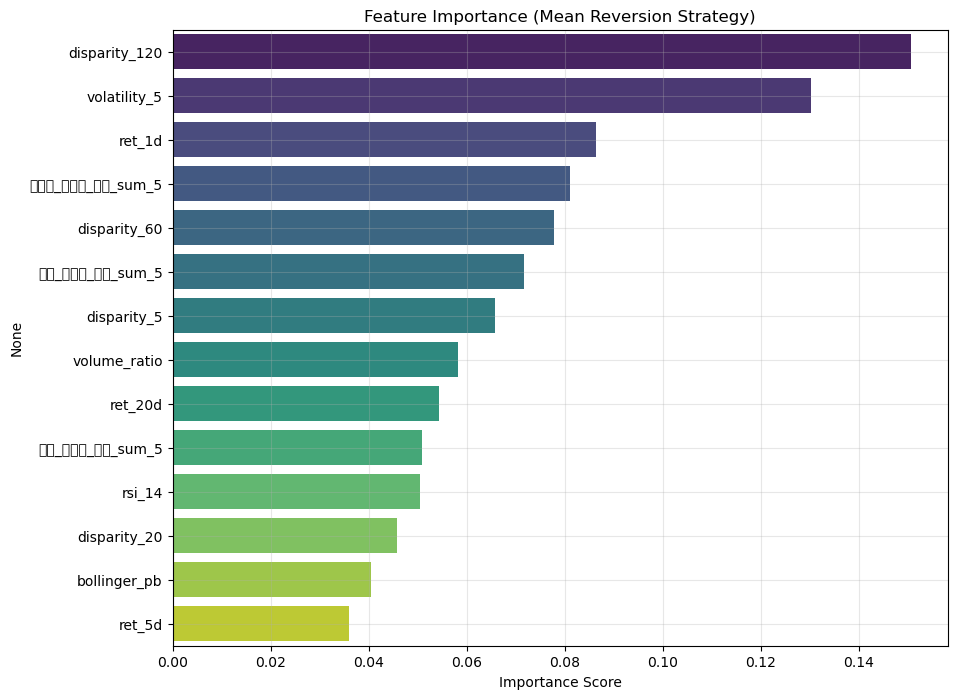


[상위 중요 지표 Top 5]
disparity_120       0.150553
volatility_5        0.130300
ret_1d              0.086429
외국인_순매수_금액_sum_5    0.080993
disparity_60        0.077896
dtype: float32


In [25]:
# ==============================================================================
# 5. Feature Importance (모델이 뭘 보고 판단했나?)
# ==============================================================================
# 중요도 추출
imp = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)

# 시각화
plt.figure(figsize=(10, 8))
sns.barplot(x=imp.values, y=imp.index, palette='viridis')
plt.title('Feature Importance (Mean Reversion Strategy)')
plt.xlabel('Importance Score')
plt.grid(True, alpha=0.3)
plt.show()

# 텍스트로 상위 5개 출력
print("\n[상위 중요 지표 Top 5]")
print(imp.head(5))

In [26]:
# ==============================================================================
# 3. 백테스트 (Top 10 매수 - 정석 모드)
# ==============================================================================
print("\n⚔️ 백테스트 시작 (Top 10 매수 + 하락장 방어)...")

# 1. 테스트 데이터 예측 실행
backtest_df = test.copy()
backtest_df['pred_rank'] = model.predict(backtest_df[features])

# 2. 리밸런싱 일정 생성 (10거래일 주기)
all_dates = sorted(backtest_df['date'].unique())
rebal_dates = all_dates[::10]

log_top10 = []
cost = 0.002  # 거래수수료 0.2%

# 3. 시뮬레이션 루프
for i in range(len(rebal_dates) - 1):
    buy_date = rebal_dates[i]
    sell_date = rebal_dates[i+1]
    
    # --- [시장 방어 로직] Market Filter ---
    # 전체 종목 중 60일 이평선 위에 있는 비율 조회
    current_breadth = 0.5
    if buy_date in df['date'].values:
        current_breadth = df[df['date'] == buy_date]['above_ma60'].mean()

    # 정배열 종목이 30% 미만이면 "폭락장" -> 매수 금지 (현금 보유)
    if current_breadth < 0.30:
        r_strategy = 0.0
        note = "🛡️ 현금 (방어)"
    else:
        # 투자 진행
        day_data = backtest_df[backtest_df['date'] == buy_date].copy()
        if len(day_data) < 20: continue

        # --- [종목 선정] 정석 전략: AI 점수 높은 상위 10개 ---
        # ascending=False (내림차순) -> 점수 높은 게 1등
        target_picks = day_data.sort_values(by='pred_rank', ascending=False).head(10)['ticker'].tolist()
        
        # 수익률 계산
        p_b = backtest_df[backtest_df['date'] == buy_date].set_index('ticker')['종가']
        p_s = backtest_df[backtest_df['date'] == sell_date].set_index('ticker')['종가']
        
        # 매수/매도일에 데이터가 모두 존재하는 종목만 계산
        valid = [t for t in target_picks if t in p_b.index and t in p_s.index]
        
        if valid:
            # (매도가 / 매수가 - 1)의 평균 - 수수료
            r_strategy = ((p_s[valid] / p_b[valid]) - 1).mean() - cost
            note = "🚀 Top 10 투자"
        else:
            r_strategy = 0.0
            note = "⚠️ 데이터 부족"

    # 4. 벤치마크 (KOSPI 200) 수익률 비교용 계산
    p_b_all = backtest_df[backtest_df['date'] == buy_date].set_index('ticker')['종가']
    p_s_all = backtest_df[backtest_df['date'] == sell_date].set_index('ticker')['종가']
    common = p_b_all.index.intersection(p_s_all.index)
    r_bm = ((p_s_all[common] / p_b_all[common]) - 1).mean()

    # 로그 저장
    log_top10.append({
        'date': sell_date, 
        'Strategy': r_strategy, 
        'Benchmark': r_bm, 
        'Note': note
    })

# 결과 DataFrame 생성
res = pd.DataFrame(log_top10).set_index('date')

print("✅ 백테스트 완료")


⚔️ 백테스트 시작 (Top 10 매수 + 하락장 방어)...
✅ 백테스트 완료



📊 [성과 리포트] 정석 Top 10 전략 (Top 10 매수 + 하락장 방어)
지표 (Metric)          | 전략 (Strategy)        | 시장 (Benchmark)      
-----------------------------------------------------------------
3년 누적 수익률            |             -46.51% |               2.28%
연환산 수익률 (CAGR)       |             -19.43% |                  -
MDD (최대낙폭)           |             -50.03% |             -19.49%
Sharpe Ratio         |              -0.50   |                  -
-----------------------------------------------------------------

📋 [상세] 리밸런싱 구간별 수익률 (최근 10회)

📅 [월별] 월간 누적 수익률 (Monthly Returns)
date
2024-01-31    -26.39%
2024-02-29    -20.79%
2024-03-31    -18.15%
2024-04-30    -25.31%
2024-05-31    -24.31%
2024-06-30    -15.62%
2024-07-31    -21.75%
2024-08-31    -34.80%
2024-09-30    -28.86%
2024-10-31    -31.06%
2024-11-30    -39.91%
2024-12-31    -46.51%
Freq: ME, Name: Strategy, dtype: object


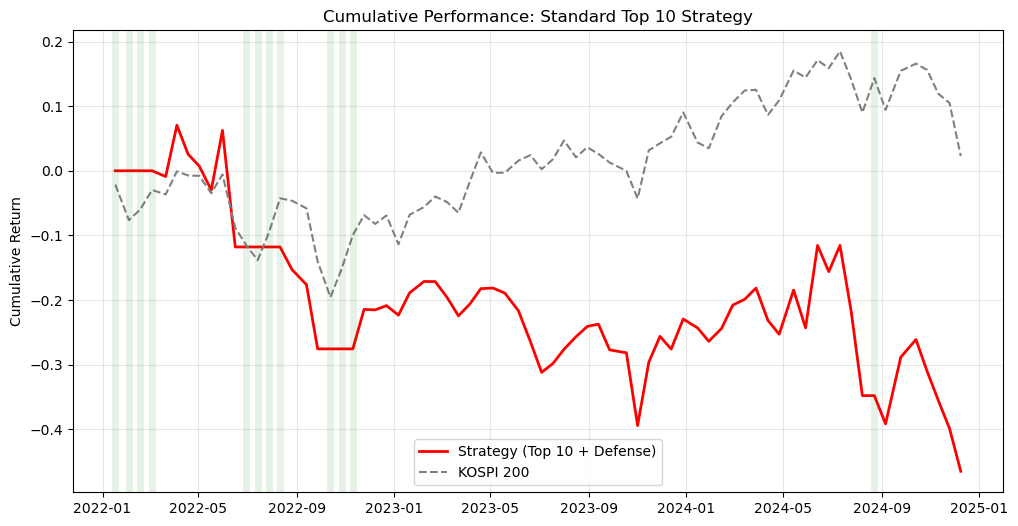

In [27]:
# ==============================================================================
# 4. 종합 성과 리포트 출력 (오류 수정 버전)
# ==============================================================================
print("\n" + "="*55)
print(f"📊 [성과 리포트] 정석 Top 10 전략 (Top 10 매수 + 하락장 방어)")
print("="*55)

# [수정] 인덱스를 날짜 형식으로 확실하게 변환 (에러 방지용)
res.index = pd.to_datetime(res.index)

# 1. 누적 수익률 계산
cum = (1 + res[['Strategy', 'Benchmark']]).cumprod() - 1
strat_final = cum['Strategy'].iloc[-1]
bm_final = cum['Benchmark'].iloc[-1]

# 2. MDD 계산
peak = (1 + res['Strategy']).cumprod().cummax()
dd = ((1 + res['Strategy']).cumprod() - peak) / peak
final_mdd = dd.min()

# 3. Sharpe Ratio (연율화, 무위험이자율 0 가정)
# 10일 주기 리밸런싱이므로 연간 약 25회 매매로 가정 (sqrt(25))
sharpe = (res['Strategy'].mean() / res['Strategy'].std()) * np.sqrt(25)

# 4. 연환산 수익률 (CAGR)
# 이제 인덱스가 datetime이므로 .days 계산이 가능합니다.
days = (res.index[-1] - res.index[0]).days
cagr = (1 + strat_final) ** (365 / days) - 1

# --- [요약표 출력] ---
print(f"{'지표 (Metric)':<20} | {'전략 (Strategy)':<20} | {'시장 (Benchmark)':<20}")
print("-" * 65)
print(f"{'3년 누적 수익률':<20} | {strat_final*100:>18.2f}% | {bm_final*100:>18.2f}%")
print(f"{'연환산 수익률 (CAGR)':<20} | {cagr*100:>18.2f}% | {'-':>18}")
print(f"{'MDD (최대낙폭)':<20} | \033[91m{final_mdd*100:>18.2f}%\033[0m | {((1+res['Benchmark']).cumprod() - (1+res['Benchmark']).cumprod().cummax()).min()*100:>18.2f}%")
print(f"{'Sharpe Ratio':<20} | {sharpe:>18.2f}   | {'-':>18}")
print("-" * 65)

# ------------------------------------------------------------------------------
# 5. 세부 내역 확인
# ------------------------------------------------------------------------------

# (1) 리밸런싱 때마다의 수익률 (구간 수익률)
print(f"\n📋 [상세] 리밸런싱 구간별 수익률 (최근 10회)")
# 스타일링 출력 시 에러가 날 경우를 대비해 값만 출력
try:
    print(res[['Strategy', 'Benchmark', 'Note']].tail(10).style.format({
        'Strategy': '{:+.2%}',
        'Benchmark': '{:+.2%}'
    }))
except:
    # Colab 등 일부 환경에서 style 오류 시 일반 출력
    print(res[['Strategy', 'Benchmark', 'Note']].tail(10))

# (2) 월별 누적 수익률
print(f"\n📅 [월별] 월간 누적 수익률 (Monthly Returns)")
# 일별 누적 수익률을 월말('ME' 또는 'M') 기준으로 리샘플링
# Pandas 버전에 따라 'M' 또는 'ME' 사용
try:
    monthly_cum = cum['Strategy'].resample('ME').last()
except:
    monthly_cum = cum['Strategy'].resample('M').last()

monthly_ret = monthly_cum.pct_change().fillna(monthly_cum.iloc[0]) # 첫 달은 누적값 그대로

# 보기 좋게 최근 12개월 출력
print(monthly_cum.tail(12).map(lambda x: f"{x*100:+.2f}%"))

# ------------------------------------------------------------------------------
# 6. 그래프 시각화
# ------------------------------------------------------------------------------
plt.figure(figsize=(12, 6))
plt.plot(cum.index, cum['Strategy'], label='Strategy (Top 10 + Defense)', color='red', linewidth=2)
plt.plot(cum.index, cum['Benchmark'], label='KOSPI 200', color='gray', linestyle='--')

# 하락장 방어 구간(현금 보유) 표시
defense_dates = res[res['Note'].str.contains("현금")].index
for d in defense_dates:
    plt.axvline(x=d, color='green', alpha=0.1, linewidth=5)

plt.title('Cumulative Performance: Standard Top 10 Strategy')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()